<a href="https://colab.research.google.com/github/Voldemort-vk/WIDS---2025/blob/main/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

#Dataset

In [25]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#Pretrained DenseNet-121

In [ ]:
model = models.densenet121(pretrained=True)

In [ ]:
for param in model.features.parameters():
    param.requires_grad = False

In [ ]:
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 10)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

#Train

In [26]:
num_epochs = 5
training_loss = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        training_loss.append(loss.item())

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/5, Loss: 0.5161
Epoch 2/5, Loss: 0.5185
Epoch 3/5, Loss: 0.5177
Epoch 4/5, Loss: 0.5139
Epoch 5/5, Loss: 0.5146


#Test

In [28]:
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Total images: {total}")
print(f"Correctly Predicted: {correct}")
print(f"Test Accuracy: {100 * correct / total:.2f}%")

Total images: 10000
Correctly Predicted: 8213
Test Accuracy: 82.13%


#Loss Plot

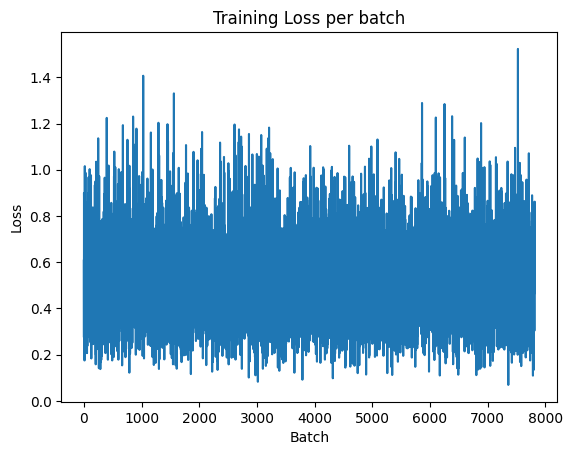

In [27]:
import matplotlib.pyplot as plt
plt.plot(training_loss)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss per batch")
plt.show()

In [29]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
Confusion_mat = confusion_matrix(all_labels, all_preds)
print(Confusion_mat)

[[889  17  17   1  16   7   0   4  35  14]
 [ 10 943   2   0   0   2   0   2   5  36]
 [ 45   4 752  21  78  46  34  14   4   2]
 [ 15  10  44 533  54 262  34  23  11  14]
 [ 11   1  33  10 816  43  33  51   0   2]
 [  4   5  16  37  22 872   7  32   1   4]
 [  7   2  36  17  38  22 869   2   4   3]
 [ 18   3  10  13  58  54   3 831   1   9]
 [ 66  25   6   6   8   4   0   1 869  15]
 [ 25 106   1   4   2   6   0   3  14 839]]


#Heat Map

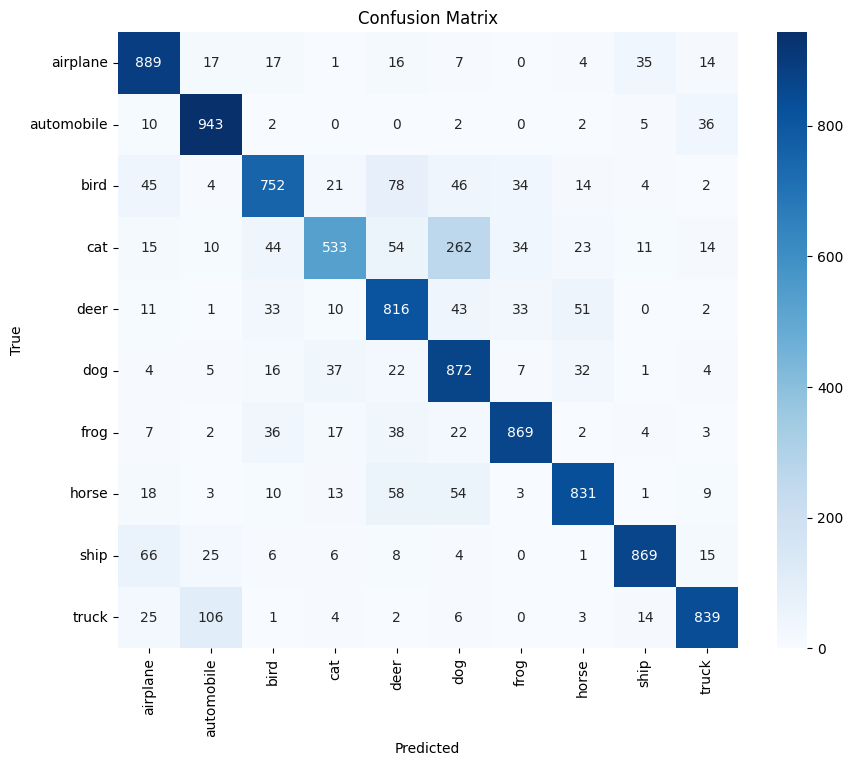

In [31]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

plt.figure(figsize=(10,8))
sns.heatmap(Confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()